### Predictions demo

I made a separate notebook for this to not accidently initialize training again on the "main" notebook birdscnn.

In [72]:
# Imports
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

##### Next code block is just copypasting all the required parts from birdscnn.ipynb notebook to get our model and Test DataLoader and such

In [73]:
mean = [0.4737, 0.4721, 0.3989]
std = [0.2029, 0.2014, 0.2066]

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

test_data = datasets.ImageFolder('./data/test', transform=transform)

birds_df = pd.read_csv('./data/classids_to_labels.csv')
birds_dict = birds_df.set_index('class id')['labels'].to_dict()

# Note batch size 25 here because I want to visualize 5x5=25 predictions.
test_loader = DataLoader(test_data, batch_size=25, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.backends.cudnn.benchmark = True
model = models.efficientnet_b4(weights=True)
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, len(birds_dict))
)
model = model.to(device)

# Load the model here
model.load_state_dict(torch.load('./best_model.pth'))
print(model.classifier)

# Just in case print device too, we want "cuda"
print(device)


Sequential(
  (0): Linear(in_features=1792, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=184, bias=True)
)
cuda


### The actual demo part

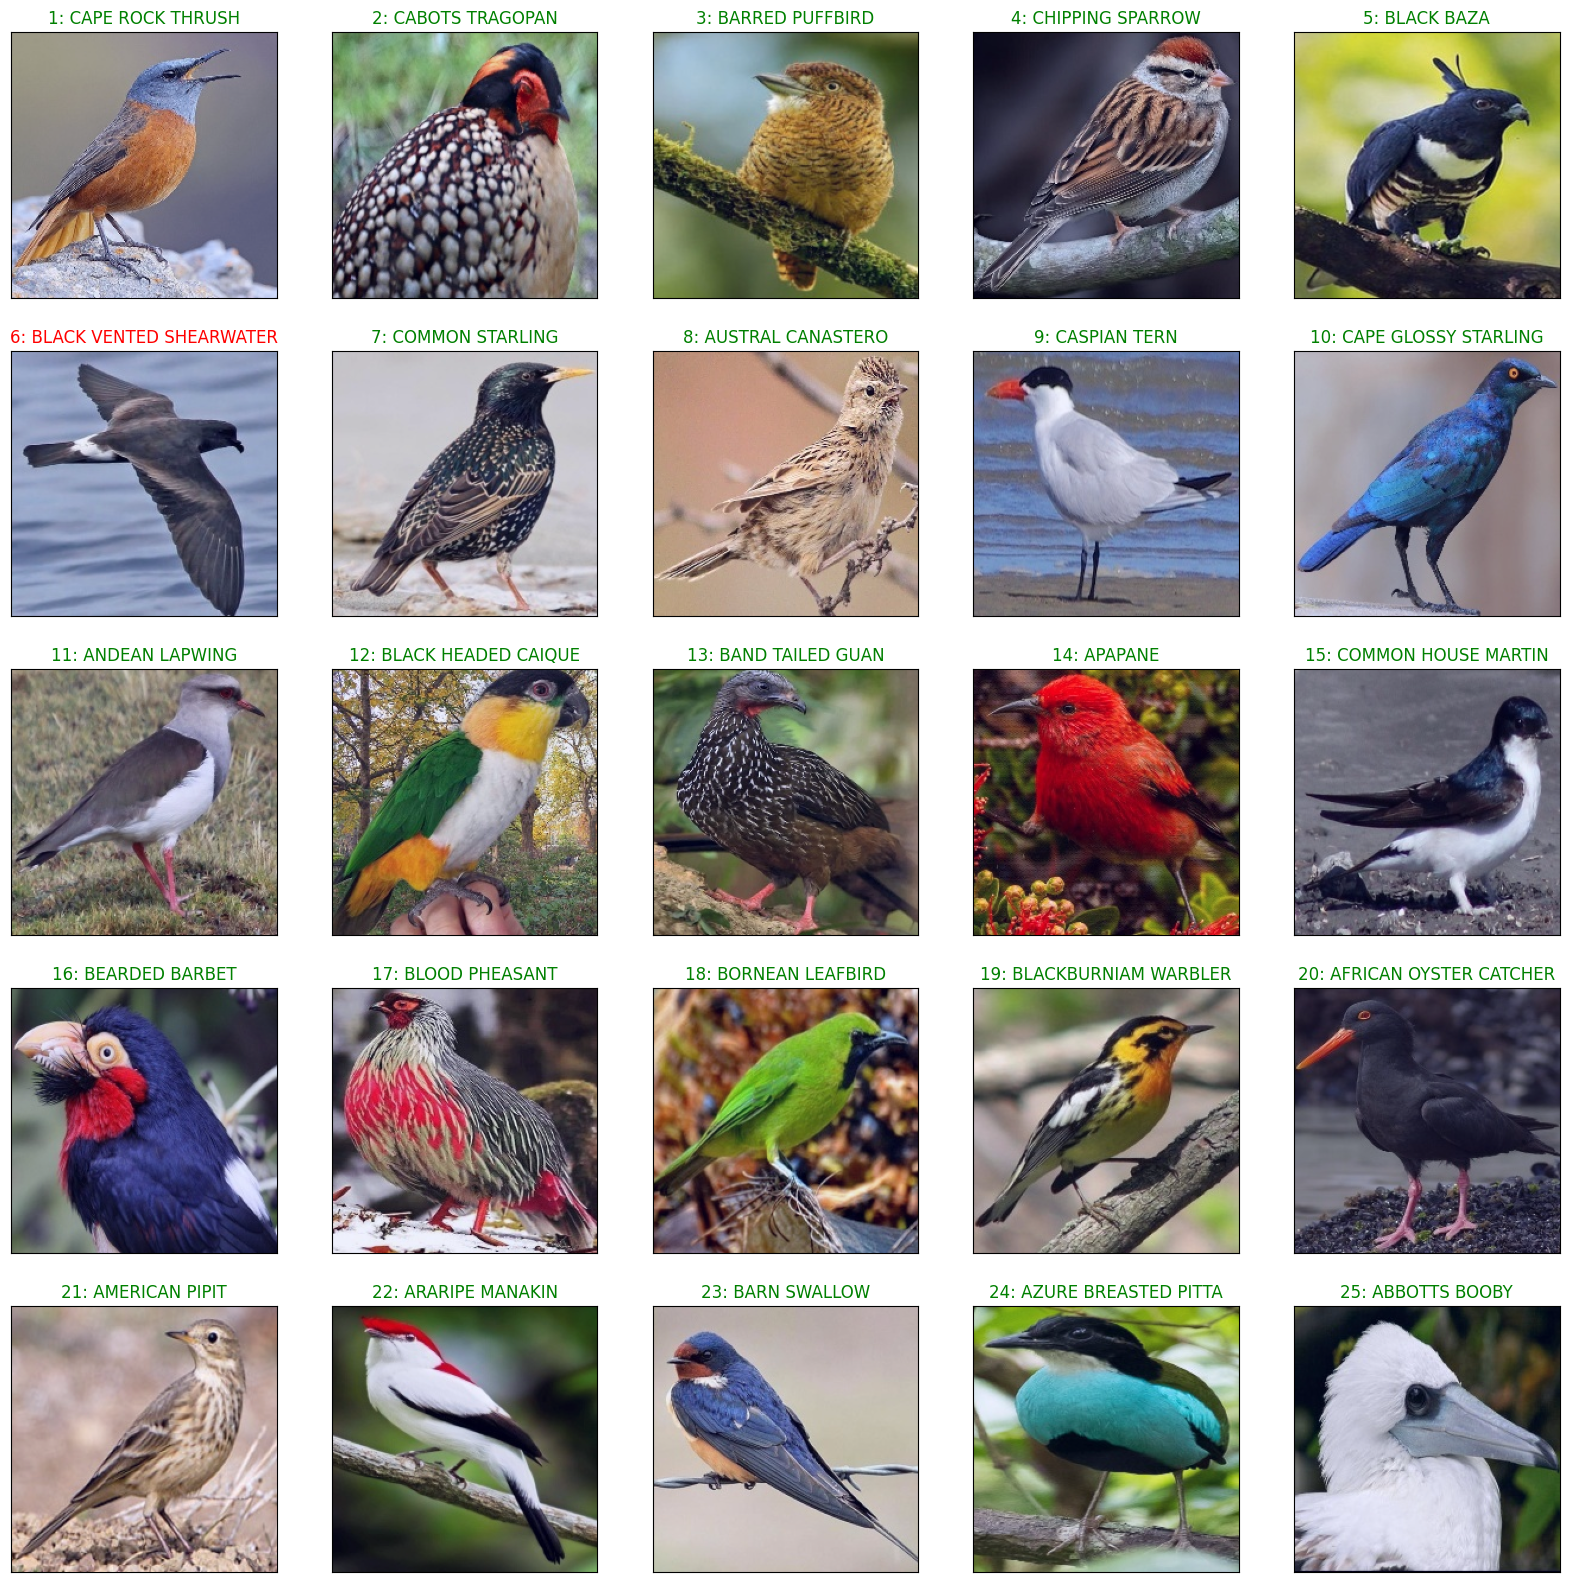

Image: 6
Predicted: BLACK VENTED SHEARWATER
Correct Label: ASHY STORM PETREL



In [74]:
# Make an iterator that always gives us a batch of 25 images and labels when called next(iterator)
test_iter = iter(test_loader)
images, labels = next(test_iter)

# Set the model to evaluation mode again
model.eval()
with torch.no_grad():
  images_cuda, labels_cuda = images.to(device), labels.to(device)
    
  # Get the predictions
  predictions = model(images_cuda)
  _, predicted_classes = torch.max(predictions.data, dim=1)

# Note: images[i] is a torch tensor in format: [Channels, Height, Width] and needs to be changed to: [Height, Width, Channels] 
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))

# List for incorrect ones
wrong_preds = []

for i, ax in enumerate(axes.flatten()):
  # This swaps the format to [Height, Width, Channels] for visualizing
  img = images[i].permute(1,2,0)
  # Change our standardization into minmax normalization for original colors
  img = (img - img.min()) / (img.max() - img.min())
  
  ax.imshow(img)
    
  # Remove x and y ticks
  ax.set_xticks([])
  ax.set_yticks([])
  
  # Predicted and true labels converted from index to actual bird name label
  predicted_label = birds_dict[predicted_classes[i].item()]
  correct_label = birds_dict[labels[i].item()]
  # If predicted == true label -> color green
  # If predicted != true label -> color red
  if (predicted_label == correct_label):
    ax.set_title(f"{i+1}: {predicted_label}", color='green')
  else:
    ax.set_title(f"{i+1}: {predicted_label}", color='red')
    wrong_preds.append(i)
    
plt.show()

# Print the correct answers for wrong predictions below the figure
for i in wrong_preds:
  print(f"Image: {i+1}\nPredicted: {birds_dict[predicted_classes[i].item()]}\nCorrect Label: {birds_dict[labels[i].item()]}\n")
  
  